In [57]:
import warnings
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

from arch import arch_model
from pmdarima.arima import auto_arima

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='innovations_mle'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [101]:
series = pd.read_csv('Лекция1/Series/international-airline-passengers.csv')['Count']
# female_births = pd.read_csv('Лекция1/Series/daily-total-female-births-in-cal.csv')['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


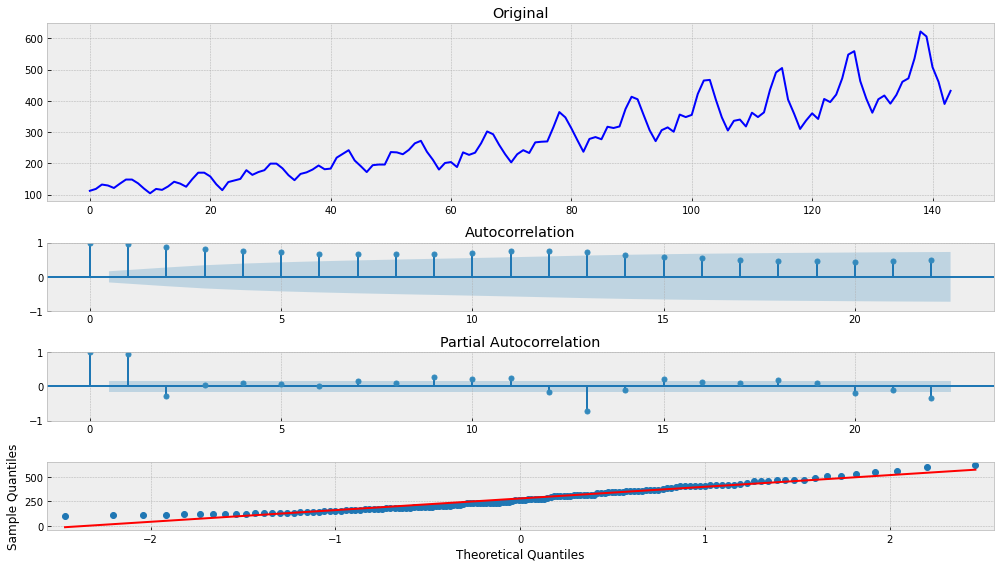

In [93]:
tsplot(series)

In [102]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]

In [104]:
train_data = series[1:len(series)-12]
test_data = series[len(series)-12:]

In [105]:
p_values = [0, 1]
d_values = range(0, 2)
q_values = range(0, 2)

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = smt.ARIMA(train_data, order=order).fit()
            predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
            error = mean_squared_error(test_data, predictions)
            print('ARIMA%s MSE=%.3f' % (order,error))

ARIMA(0, 0, 0) MSE=0.003
ARIMA(0, 0, 1) MSE=0.003
ARIMA(0, 1, 0) MSE=0.004
ARIMA(0, 1, 1) MSE=0.003
ARIMA(1, 0, 0) MSE=0.003
ARIMA(1, 0, 1) MSE=0.003
ARIMA(1, 1, 0) MSE=0.004
ARIMA(1, 1, 1) MSE=0.003


In [106]:
_get_best_model(series)

aic: -461.67133 | order: (4, 0, 3)


(-461.6713323697186,
 (4, 0, 3),
 <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x19bce6a0d00>)

In [111]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 4
o_ = 0
q_ = 3

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                229.614
Distribution:      Standardized Student's t   AIC:                          -439.228
Method:                  Maximum Likelihood   BIC:                          -410.476
                                              No. Observations:                  131
Date:                      Fri, Oct 28 2022   Df Residuals:                      130
Time:                              10:23:57   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


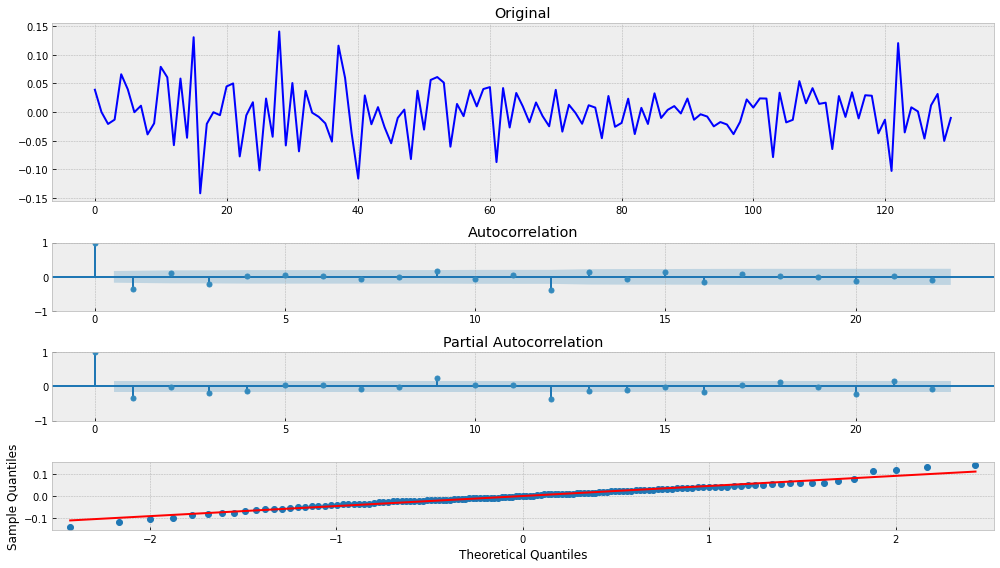

In [110]:
tsplot(res.resid)